### mfFCA: multi-frame Full-rank spatial Covariance Analysis
### sample code for synthetic mixtures

In [1]:
# import numpy and matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import our own code
import fca
import spatial_white

In [2]:
# some utility functions for generating synthetic mixtures
def random_complex(shape, normalize=False):
    real = np.random.randn(*shape)
    imag = np.random.randn(*shape)
    cmplx = real + 1.j * imag
    if normalize:
        eps = np.spacing(1)
        scale = np.sqrt(real**2 + imag**2)
        scale = np.maximum(scale, eps)
        return cmplx / scale
    else:
        return cmplx


def make_mixtures(num_sources, delay_scales, num_samples, num_sensors, num_bins):
    noise_power = 1e-3
    current_delay_scales = (1, ) + delay_scales
    a_list = []
    for scale in current_delay_scales:
        a = scale * random_complex((num_sources, num_bins, num_sensors), normalize=True)
        a_list.append(a)
    #
    s = np.random.gamma(shape=1, scale=1, size=(num_sources, num_samples))
    #
    x = noise_power * random_complex((num_samples, num_bins, num_sensors))
    for shift, a in enumerate(a_list):
        c = np.einsum('nt,nfm->ntfm', s, a)
        csum = c.sum(axis=0)
        if shift > 0:
            zeros_shape = (shift,) + csum.shape[1:]
            csum = np.concatenate((np.zeros(zeros_shape), csum[:-shift]))
        x += csum
    return x, s

In [3]:
# some settings
num_sources = 3
num_sensors = 2
delay_scales = (0.3, 0.1)
num_samples = 100
num_bins = 10
# generate synthetic mixtures
x, s = make_mixtures(num_sources, delay_scales, num_samples, num_sensors, num_bins)
print(x.shape)

(100, 10, 2)


In [4]:
# perform spatial whitening
whitening = spatial_white.SpatialWhitening(x)
xsw = whitening.apply(x)

In [5]:
# perform mfFCA
nLoop = 20
bss = fca.mfFCA(xsw, num_sources)
bss.report_scale()
bss.set_freqGroup(num_bins)
bss.optimizationEM(nLoop)
delay_list = ((1,), (2,))
for d in delay_list:
    bss.append_delay_list(d)
    bss.optimizationEM(nLoop)
for i in range(2):
    bss.optimizationEM(nLoop)
bss.report_scale()

s 1.0 A 1.0
s 0.4620677516837283 A 0.18680458617051154


Text(0, 0.5, 'cost function')

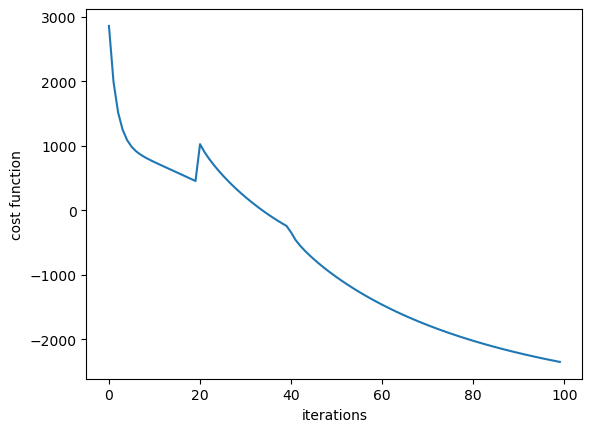

In [6]:
# see how the cost function decreases as iterations go on
plt.plot(bss.losshist)
plt.xlabel('iterations')
plt.ylabel('cost function')

In [7]:
# get early and late separated signals
y_early, y_late = bss.early_late_separated_signals()
y_early = whitening.recover(y_early)
y_late = whitening.recover(y_late)

Text(0.5, 0, 'Time frames')

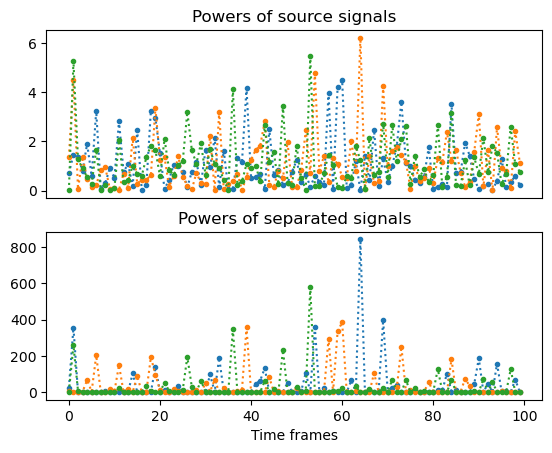

In [8]:
# see the separation has been successful or not
ypow = (y_early * y_early.conj()).sum(axis=(2, 3)).real
ax = plt.subplot(2, 1, 1)
plt.plot(s.T, '.:')
plt.title('Powers of source signals')
ax.axes.xaxis.set_ticks([])
plt.subplot(2, 1, 2)
plt.plot(ypow, '.:')
plt.title('Powers of separated signals')
plt.xlabel('Time frames')

#### How to observe the figures above
In the figures above, the colors correspond to the sources. Due to the nature of blind source separation, the order may be permuted between sources and separated signals. Therefore, please allow for color permutation. Then, we can say that the separation was successful if the time frames in which the source powers are large coincide, and otherwise the separation was not successful.